# Cross-Sell Analysis

The following is an exploration of the dataset provided for the creation of a cross-selling algorithm. The cross-selling algorithm will recommend up to five activities to the user that it thinks they will likely book.

These five will include a mixture of personal, popular and timely recommendations depending on the data.

As input, the algorithm will take:
- country user is viewing
- activities user has viewed

Assumptions:
- user is browsing in just one country

Can we do any clustering?
Drop all activities with less than 5 bookings.
could also train a neural net. Given the current activities, what are the probabilities of next.

## Initial Look

In [1]:
import pandas as pd
import seaborn as sns
from datetime import datetime
from sklearn.metrics.pairwise import cosine_similarity

# read data
data = pd.read_csv('data.csv')

# let's take a look
data.head()

,order_id,guest_id,activity id,activity_name,date_booking,country_activity,device_type
0,102060,110254,3056,Activity 3056,29/10/16,Singapore,Mobile
1,84694,7778,1063,Activity 1063,5/9/16,Japan,PC
2,68495,88481,3088,Activity 3088,8/7/16,Singapore,Mobile
3,106751,133893,7092,Activity 7092,12/11/16,Singapore,PC
4,96985,122707,800,Activity 800,15/10/16,Indonesia,PC


Do we have any null values?

In [2]:
data.isnull().sum()

order_id              0
guest_id              0
activity id           0
activity_name         0
date_booking          0
country_activity      0
device_type         368
dtype: int64

We're missing some device types, but that's OK as we won't be using these anyway.

It seems that activity id and activity_name are duplicate columns, let's check this. While we're at it, we'll rename activity id which seems to be incorrectly spelt.

In [3]:
# remove text and convert to int then check matches
print(sum(data['activity id']!=data['activity_name'].apply(lambda x: int(x[9:]))))
# rename 
data = data.rename(index=str, columns={"activity id": "activity_id"}).drop(['activity_name'], axis=1)

0


In [4]:
print(len(data.order_id.value_counts()),"orders")
print(len(data.guest_id.value_counts()),"guests")
print(len(data.activity_id.value_counts()),"activities")

29034 orders
24882 guests
908 activities


So we see there are 29,034 unique orders coming from 24,882 guests. This means that at most we have ~5,000 guests who make more than one order, which will make building personal recommendations fairly difficult based just off customer preferences.

To expand the dataset we might want to look at where they are booking from (though we don't have access to that here) and when they are booking.

We can also look at the split across countries.

In [5]:
data.groupby(['country_activity']).nunique()

,order_id,guest_id,activity_id,date_booking,country_activity,device_type
country_activity,,,,,,
India,1,1,1,1,1,1
Indonesia,5865,5242,118,214,1,2
Japan,9363,7976,692,214,1,2
Malaysia,16,16,1,13,1,2
Singapore,12106,10351,36,210,1,2
Taiwan,27,26,7,24,1,2
Thailand,1649,1469,50,212,1,2
Vietnam,8,8,4,8,1,2


So we see that the recommendations will only really be applicable to four countries: Indonesia, Japan, Singapore and Thailand.

Earlier, we decided to leave out the device type from our analysis, let's check that it's justified by looking at the correlation between the activities booked and the device used. Firstly, let's plot and then, let's calculate the Pearson correlation.

(0.9425119113103545, 0.0)


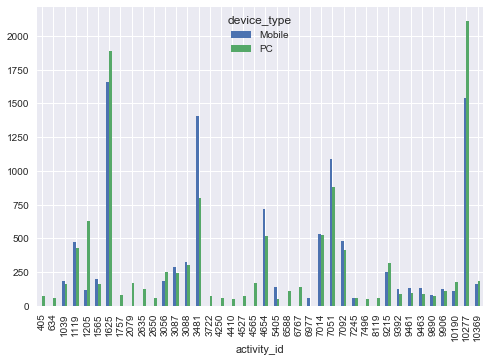

In [6]:
grpd = data.groupby(['device_type'])['activity_id'].value_counts()
stats = grpd.unstack(level=0).fillna(0)
from scipy.stats.stats import pearsonr   
print(pearsonr(stats['Mobile'].values,stats['PC'].values))
grpd = grpd[grpd > 50]
grpd.unstack(level=0).plot(kind='bar')
sns.plt.show()


Looking at the graph we see that there is no noticeable trend and the Pearson correlation of 0.94 suggests that they are highly correlated, thus we don't need to differentiate for now.

How long does it take users to book again after their first booking?

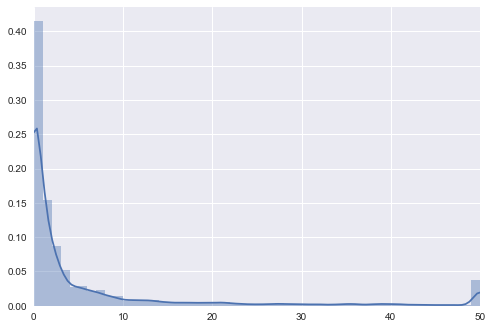

In [9]:
from datetime import timedelta
def spec_sort(l):
    if not l:
        return None
    if len(l) < 2:
        return None
    l.sort()
    ans = []
    for i in range(len(l)-1):
        ans += [int((l[i+1] - l[i]) / timedelta(1))]
    return ans

l = data.groupby(['guest_id'])['date_booking'].apply(list).apply(spec_sort).tolist()
t = [a for a in l if a]
flat_list = [item for sublist in t for item in sublist] # if item > 0]
t = flat_list
flat_list = [min(a,50) for a in t]
chart = sns.distplot(flat_list)
chart.axes.set_xlim(0,50)
sns.plt.show()


So most people book on the same day or within a few days, that is, for the same holiday. There are very few repeat users, but this makes sense given the size of the dataset is just 6 months - people don't take holidays that often.

Now let's have a look at the three areas of recommendations discussed earlier.

## Dates & Seasonality

Let's have a look at the bookings through time and see if we can identify any trends.

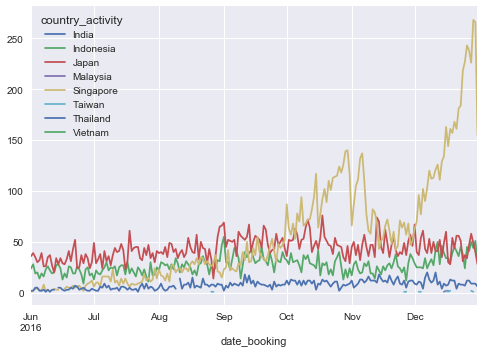

In [8]:
# convert to datetime
data['date_booking'] = data['date_booking'].apply(lambda x: datetime.strptime(x,'%d/%m/%y'))
# plot purchases in time
country_booking_dates = data.groupby(['country_activity'])['date_booking'].value_counts().sort_index()
country_booking_dates.unstack(level=0).plot(kind='line')
sns.plt.show()

So we see that there actually isn't much seasonality in the data, only in Singapore do we see a steep rise around November and December. Let's investigate more the activities to see if there are certain activities bringing people to travel.

Note that it appears that Singapore has only started to grow which suggests launch actually only happened in June, this makes it difficult to see timely trends.

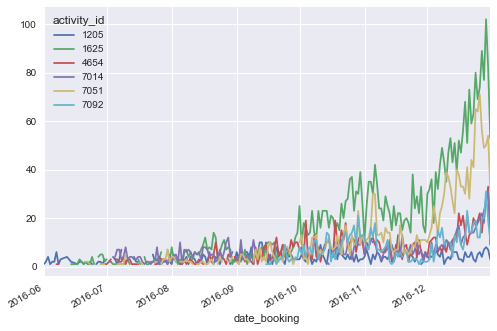

In [10]:
sg_act_book = data[data['country_activity']=='Singapore'].groupby(['activity_id'])['date_booking'].value_counts().sort_index()
# get popular activities
top_sg_act = data[data['country_activity']=='Singapore']['activity_id'].value_counts().index[6:]
for act in top_sg_act:
    sg_act_book = sg_act_book.loc[sg_act_book.index.get_level_values('activity_id') != act]
# plot
sg_act_book.unstack(level=0).plot(kind='line')
sns.plt.show()

Well it seems that just a few activities are responsible for the peaks, they also happen to be the most popular activities year round, so this may not be the effect of seasonality of the activity, but of the region.

With the current data there is no 'seasonal' recommendation to make as all the major activities are booked year-round.

## Popular Recommendations

Next we want to see what activities are most popular to recommend to users.

Let's have a look at the most popular activities in each country.

In [11]:
for country in data['country_activity'].unique():
    print(country)
    print(data[data['country_activity']==country].activity_id.value_counts()[:5])

Singapore
1625    3555
7051    1972
4654    1236
7014    1055
7092     895
Name: activity_id, dtype: int64
Japan
10277    3657
10190     289
2079      211
4565      185
6767      168
Name: activity_id, dtype: int64
Indonesia
3481    2208
1119     900
9215     573
3087     539
1039     347
Name: activity_id, dtype: int64
Thailand
9461    233
9463    222
9392    214
5405    197
9890    155
Name: activity_id, dtype: int64
Taiwan
7623    11
1872     7
2090     5
2054     1
7637     1
Name: activity_id, dtype: int64
Malaysia
7666    16
Name: activity_id, dtype: int64
Vietnam
1006    3
2178    3
791     1
1205    1
Name: activity_id, dtype: int64
India
782    1
Name: activity_id, dtype: int64


We see that for the three major cities there is one activity which is booked significantly more than others. This should always be recommended.

## Personal Recommendations

We'd like to make personal recommendations based on what the user has previously booked or viewed on the website. We can do this by building a similarity matrix between activities.

First, let's check we have enough data.

In [12]:
print("{} guests with more than one booking".format(sum(data['guest_id'].value_counts()>1)))
print("{} guests with bookings in more than one country".format(sum(data.groupby(['guest_id'])['country_activity'].nunique() > 1)))

3036 guests with more than one booking
203 guests with bookings in more than one country


Average lead time between bookings
Are they repeat users or multiple bookings?

In order to make personal recommendations, let's build up a similarity matrix. We will use the cosine similarity matrix. We start by building a matrix with products as rows and users as columns.

In [18]:
# if we have different things, like product views instead of purchases, +0.25, +0.5, etc.
data['value'] = 1
cosine_matrix = pd.pivot_table(data, values='value', index='activity_id', columns='guest_id', aggfunc=sum, fill_value=0)

# take column averages to avoid weighting repeat buyers heavily, each user is as important as the next
# not an issue at this stage though
#for col in cosine_matrix.columns:
#    cosine_matrix[col] = cosine_matrix[col] / cosine_matrix[col].sum()

similarities = cosine_similarity(cosine_matrix.values)

In [19]:
similarities_df = pd.DataFrame(similarities, 
                               index=data.activity_id.sort_values().unique(),
                               columns=data.activity_id.sort_values().unique())

With this matrix, we can now work out which are the most popular activities that match the current activity. For example, if the customer is looking at activity 5405, we would recommend:

In [20]:
def similar_activities(activity, num=5):
    return list(filter(lambda a: a != activity, similarities_df[activity].sort_values(ascending=False)[:num+1].index.tolist()))[:num]
    
print("Recommended activities: {0}".format(similar_activities(5405)))

Recommended activities: [5275, 5279, 9392, 9463, 5389]


This can be extrapolated to account for customers looking at multiple activities as well as taking into account weights for customers who have viewed / added to cart / checked out on different activities.

Definitely more algorithms we could try: https://www.slideshare.net/NYCPredictiveAnalytics/building-a-recommendation-engine-an-example-of-a-product-recommendation-engine
https://www.quora.com/Which-algorithms-are-used-in-recommender-systems
https://www.slideshare.net/koeverstrep/tutorial-bpocf

plot similarity matrix with cosines for top activities

## Final

So we have seen that the seasonal recommendations aren't very relevant with the current dataset so our final five recommendations will come from:
- two popular recommendations (based on country viewing)
- three personal recommendations (based on activities viewed)

Let's see how this would look.

In [21]:
# calculate an activity dict so we know which country an activity is in
activity_dict = data.drop_duplicates(subset=['activity_id', 'country_activity']
                                    ).drop(['order_id', 'guest_id','date_booking', 'device_type'], axis=1
                                          ).set_index('activity_id')['country_activity'].to_dict()

In [22]:
def recommend(activity):
    country = activity_dict[activity]
    recommended = get_popular(country, 2)
    personal = [x for x in similar_activities(activity, 6) if x not in recommended + [activity]]
    recommended = personal[:3] + recommended
    return recommended
    
def get_popular(country, num=5):
    return data[data['country_activity']==country].activity_id.value_counts().sort_values(ascending=False)[:num].index.tolist()

print("Recommended activites are:")
for index, act in enumerate(recommend(5405)):
    print(str(index+1)+".", act)

Recommended activites are:
1. 5275
2. 5279
3. 9392
4. 9461
5. 9463


With the current dataset the personal recommendations are bound to look similar to the popular recommendations as the data is heavily skewed towards just a few activities. However, with the recommendation above, you can see that 5725 and 5729 were chosen, despite not being in the top 5 popular activities for Thailand.

Some recommendations:
- get view / click data to improve the model knowledge
- combine different algorithms for personal recommendations (e.g. kNN, SVD)
- get long term data to understand seasonality better
- deploy as microservice which allows for website to query and/or store in excel for marketing use with emails
- identify products which can be purchased multiple times (e.g. restaurant vouchers) and look at reselling these
- think about cross-country selling, if they're booking in Japan, how much should we cross-sell Taiwan
- assume that the user doesn't want to book the activity again, but for something like retargeting email, they may want to repeat their purchase as we see with some users.
- manually filter out events that aren't applicable for that time of year with some sort of 'decay' parameter.

## Evaluation

We can test the validity of our model by looking at guests with more than one order and trying to predict what their next product will be, given their previous purchases.

Start by building up test cases.

In [23]:
test_guests = data.groupby(['guest_id'])['order_id'].count()
test_guests = test_guests[test_guests > 1].index.tolist()
# build activity lists
guest_activities = dict(zip(test_guests, [[] for i in range(0, len(test_guests))]))
data_sorted = data.sort_values(['date_booking'], axis=0)
for index, row in data_sorted.iterrows():
    if row['guest_id'] in test_guests:
        guest_activities[row['guest_id']] += [row['activity_id']]
    
print("Selected customers")
for row in [(a, guest_activities[a]) for a in guest_activities.keys()][:20]:
    print(row)

Selected customers
(29, [7245, 4654, 7092])
(613, [4654, 9392])
(858, [964, 2858])
(4114, [7776, 3023])
(4118, [2636, 10190])
(4600, [7574, 3722])
(5169, [5728, 5369, 5728])
(6935, [1205, 4241])
(7778, [2244, 10277, 1063])
(9372, [10277, 1205])
(9474, [1625, 1625])
(11643, [2273, 9461])
(11994, [7583, 6656, 4572, 6951, 440, 2969])
(15352, [3639, 9215])
(16715, [4241, 6588])
(17461, [2703, 2703, 5581, 2703, 5581])
(17569, [10277, 10277])
(17632, [3087, 1620, 1469])
(17755, [3503, 3503])
(17908, [1205, 10277])


In [24]:
# build a dataframe to test
test_cases = []
for key in guest_activities.keys():
    for i in range(0, len(guest_activities[key])-1):
        test_cases += [[guest_activities[key][i], guest_activities[key][i+1]]]

test_cases = pd.DataFrame(test_cases, columns=['in','out'])
test_cases.head()

,in,out
0,7245,4654
1,4654,7092
2,4654,9392
3,964,2858
4,7776,3023


In [25]:
# perform a test
correct = 0
for index, row in test_cases.iterrows():
    if row['out'] in recommend(row['in']):
        correct += 1
        
print("{} correct out of {}".format(correct, test_cases.shape[0]))

2082 correct out of 4153


In [26]:
# how does this compare to just predicting popular?
correct = 0
for index, row in test_cases.iterrows():
    if row['out'] in get_popular(activity_dict[row['in']],5):
        correct += 1
        
print("{} correct out of {}".format(correct, test_cases.shape[0]))

1933 correct out of 4153


Great, so we see our personal recommendations provide an improvement of 8% over the most popular, but this is still not great. Where are we going wrong? Looking at the test cases we can see that there are actually a lot of repeat bookings for certain events which are model didn't account for. This is where a neural net would be superior.